In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict, plot_regression_results_interactions_from_dict, plot_cat_by_cat_variable
import numpy as np
from regression import likelihood_ratio_test_all, fit_nb_with_alpha_all_codes,transform_vars_for_regression, fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [3]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews.csv').drop_duplicates()

In [4]:
from processing import calculate_uniqueness, calculate_uniqueness_two_columns

# how should uniqueness decay?
df_crawled.event_date = pd.to_datetime(df_crawled.event_date)
df_crawled = calculate_uniqueness(df_crawled, 30, 'country')
df_crawled = calculate_uniqueness(df_crawled, 30, 'cat')
df_crawled = calculate_uniqueness_two_columns(df_crawled, 30, 'country', 'cat')

In [183]:
df_crawled[df_crawled.pagetitle.str.contains('Lista')]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,in_code_region,date_month,views_baseline,view_country_article,country_articles,country_articles_log,cat_articles,cat_articles_log,country_cat_articles,country_cat_articles_log


In [5]:
df_reg = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.event_date.dt.year >= 2016) & (df_crawled.views_7_sum > 10)].copy()
df_reg = transform_vars_for_regression(df_reg)

In [159]:
df_reg.to_csv('events/new/df_regression.csv', index=False)

In [109]:
code_reg = 'C(code, Treatment(reference="en"))'
cat_reg = 'C(cat, Treatment(reference="sports"))'
class_reg = 'C(gni_class, Treatment(reference="H"))'
region_reg = 'C(gni_region, Treatment(reference="North America"))'
continent_reg = 'C(continent, Treatment(reference="North America"))'

#features_no_rq = [cat_reg, 'population_log', 'country_articles_log', 'cat_articles_log', 'country_cat_articles_log', 'views_baseline_log', 'view_country_article_log', 'planned', 'breaking']
features_control = [cat_reg, 'population_log', 'country_articles_log', 'cat_articles_log', 'country_cat_articles_log', 'views_baseline_log', 'planned', 'breaking']# 'view_country_article_log', 
features_no_red = [cat_reg, 'population_log','country_cat_articles_log', 'views_baseline_log', 'planned', 'breaking']# 'view_country_article_log', 
features_no_bin = [cat_reg, 'population_log','country_cat_articles_log', 'views_baseline_log']# 'view_country_article_log', 

features_rq_1 = features_no_red + [class_reg, f'{class_reg}:{cat_reg}']
features_rq_1a = features_no_red + ['GDP_pc_log', f'GDP_pc_log:{cat_reg}']
features_rq_2 = features_no_red + [region_reg, f'{region_reg}:{cat_reg}']
features_rq_2a = features_no_red + [continent_reg, f'{cat_reg}:{continent_reg}']
features_both = features_no_red + [class_reg, region_reg, f'{region_reg}:{cat_reg}', f'{class_reg}:{cat_reg}']

features_rq_1_nobin = features_no_bin + [class_reg, f'{cat_reg}:{class_reg}']
features_rq_1a_nobin = features_no_red + ['GDP_pc_log', f'GDP_pc_log:{cat_reg}']
features_rq_2_nobin = features_no_bin + [region_reg, f'{cat_reg}:{region_reg}']
features_both_nobin = features_no_bin + [class_reg, region_reg, f'{cat_reg}:{class_reg}', f'{cat_reg}:{region_reg}']

In [7]:
codes = ['en', 'es', 'de', 'it']

In [162]:
fit_rq1['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 6695
Model:                            GLM   Df Residuals:                     6674
Model Family:        NegativeBinomial   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77521.
Date:                Wed, 25 May 2022   Deviance:                       1570.7
Time:                        11:50:59   Pearson chi2:                 6.28e+03
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           3.9704      0.570      6.961      0.000       2.853       5.088
cat[T.culture]                      0.2483      0.207      1.200      0.230      -0.157       0.654
cat[T.disaster]                     3.2697      0.276     11.851      0.000       2.729       3.811
cat[T.politics]                     0.3938      0.150      2.619      0.009       0.099       0.689
planned[T.True]                     2.0058      0.176     11.388      0.000       1.661       2.351
breaking[T.True]                   -0.3523      0.247     -1.428      0.153      -0.836       0.131
gni_class[T.L]                      0.8414      1.517      0.555      0.579      -2.132       3.815
gni_class[T.LM]                     0.4336      0.320      1.357      0.175      -0.193       1.060
gni_class[T.UM]                     0.6069      0.198      3.073      0.002       0.220       0.994
gni_class[T.L]:cat[T.culture]      -3.3845      2.752     -1.230      0.219      -8.778       2.009
gni_class[T.LM]:cat[T.culture]     -1.3220      0.620     -2.133      0.033      -2.536      -0.108
gni_class[T.UM]:cat[T.culture]     -0.5860      0.631     -0.928      0.353      -1.823       0.651
gni_class[T.L]:cat[T.disaster]     -0.4963      1.583     -0.314      0.754      -3.599       2.606
gni_class[T.LM]:cat[T.disaster]    -0.8250      0.484     -1.703      0.089      -1.774       0.124
gni_class[T.UM]:cat[T.disaster]    -0.4651      0.414     -1.124      0.261      -1.276       0.346
gni_class[T.L]:cat[T.politics]      1.8393      1.630      1.128      0.259      -1.356       5.035
gni_class[T.LM]:cat[T.politics]     0.1259      0.428      0.294      0.769      -0.713       0.965
gni_class[T.UM]:cat[T.politics]     0.4052      0.327      1.238      0.216      -0.236       1.046
population_log                      0.0600      0.055      1.084      0.278      -0.048       0.168
country_cat_articles_log           -0.0183      0.052     -0.355      0.723      -0.119       0.083
views_baseline_log                  0.1671      0.045      3.737      0.000       0.079       0.255
===================================================================================================
"""

In [170]:
alpha_dict = {}
fit_0 = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_reg, f'views_7_sum ~ {"+".join(features_no_red)}', 
    est_method='IRLS', output_lvl=1, alpha_dict=alpha_dict)

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.79 (p=0.0002)
Deviance: 1604.70 | Null-deviance: 1792.47 | Pseudo R² (1 - D/D_0) = 0.1048
Pseudo ChiSq: 7201.91 | Good-Fit-ChiSq: 6877.34 | Residual DF: 6686
AIC: 155093.78 | BIC: -57293.05
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.08
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 15.52 (p=0.0000)
Deviance: 608.51 | Null-deviance: 769.68 | Pseudo R² (1 - D/D_0) = 0.2094
Pseudo ChiSq: 3024.79 | Good-Fit-ChiSq: 2927.28 | Residual DF: 2803
AIC: 56292.21 | BIC: -21651.94
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.08
________________________________________________________________________________________________
================= Fitting de =========

In [171]:
fit_0_nobin['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 6695
Model:                            GLM   Df Residuals:                     6688
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -77810.
Date:                Mon, 30 May 2022   Deviance:                       1598.1
Time:                        08:13:42   Pearson chi2:                 6.66e+03
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.6404      0.557     10.124      0.000       4.548       6.732
cat[T.culture]               0.0287      0.187      0.153      0.878      -0.338       0.396
cat[T.disaster]              1.0277      0.170      6.042      0.000       0.694       1.361
cat[T.politics]              0.3628      0.131      2.765      0.006       0.106       0.620
population_log               0.1736      0.043      4.022      0.000       0.089       0.258
country_cat_articles_log     0.0036      0.050      0.073      0.942      -0.094       0.101
views_baseline_log           0.0800      0.029      2.772      0.006       0.023       0.137
============================================================================================
"""

In [10]:
alpha_dict_nobin = {}
fit_0_nobin = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_reg, f'views_7_sum ~ {"+".join(features_no_bin)}', 
    est_method='lbfgs', output_lvl=1, alpha_dict=alpha_dict_nobin)

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.57 (p=0.0003)
Deviance: 1598.05 | Null-deviance: 1708.45 | Pseudo R² (1 - D/D_0) = 0.0646
Pseudo ChiSq: 6660.20 | Good-Fit-ChiSq: 6879.37 | Residual DF: 6688
AIC: 155634.38 | BIC: -57317.32
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.00
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 18.74 (p=0.0003)
Deviance: 583.51 | Null-deviance: 637.26 | Pseudo R² (1 - D/D_0) = 0.0843
Pseudo ChiSq: 3341.37 | Good-Fit-ChiSq: 2929.33 | Residual DF: 2805
AIC: 57178.47 | BIC: -21692.82
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.19
________________________________________________________________________________________________
================= Fitting de =========

In [176]:
fit_0_nobin_region['en'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 6695
Model:                            GLM   Df Residuals:                     6682
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -77724.
Date:                Mon, 30 May 2022   Deviance:                       1614.0
Time:                        08:18:20   Pearson chi2:                 7.19e+03
No. Iterations:                    62                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    5.9241      0.831      7.129      0.000       4.295       7.553
cat[T.culture]                               0.1011      0.191      0.530      0.596      -0.273       0.475
cat[T.disaster]                              0.9682      0.176      5.491      0.000       0.623       1.314
cat[T.politics]                              0.3550      0.135      2.621      0.009       0.090       0.621
gni_region[T.East Asia & Pacific]            0.0644      0.223      0.289      0.772      -0.372       0.501
gni_region[T.Europe & Central Asia]         -0.0524      0.188     -0.279      0.781      -0.421       0.316
gni_region[T.Latin America & Caribbean]      0.2553      0.255      0.999      0.318      -0.245       0.756
gni_region[T.Middle East & North Africa]     0.6581      0.351      1.873      0.061      -0.031       1.347
gni_region[T.South Asia]                    -0.0672      0.336     -0.200      0.842      -0.726       0.592
gni_region[T.Sub-Saharan Africa]             0.3408      0.416      0.819      0.413      -0.474       1.156
population_log                               0.1205      0.047      2.582      0.010       0.029       0.212
country_cat_articles_log                    -0.0057      0.057     -0.100      0.920      -0.117       0.105
views_baseline_log                           0.1141      0.043      2.672      0.008       0.030       0.198
============================================================================================================
"""

In [174]:
fit_0_nobin_region = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_reg, f'views_7_sum ~ {"+".join(features_no_bin + [region_reg])}', 
    est_method='lbfgs', output_lvl=1, alpha_dict=alpha_dict_nobin)

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 16.30 (p=0.0002)
Deviance: 1614.04 | Null-deviance: 1736.58 | Pseudo R² (1 - D/D_0) = 0.0706
Pseudo ChiSq: 7192.99 | Good-Fit-ChiSq: 6873.28 | Residual DF: 6682
AIC: 155474.54 | BIC: -57248.48
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.08
________________________________________________________________________________________________
================= Fitting es =================
Estimated alpha as 16.35 (p=0.0000)
Deviance: 636.24 | Null-deviance: 730.65 | Pseudo R² (1 - D/D_0) = 0.1292
Pseudo ChiSq: 3298.29 | Good-Fit-ChiSq: 2923.19 | Residual DF: 2799
AIC: 56578.49 | BIC: -21592.44
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.18
________________________________________________________________________________________________
================= Fitting de =========

In [55]:
fit_rq1 = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_rq_1)})', alpha_dict, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1570.72 | Null-deviance: 1792.53 | Pseudo R² (1 - D/D_0) = 0.1237
Pseudo ChiSq: 6283.72 | Good-Fit-ChiSq: 6865.17 | Residual DF: 6674
AIC: 155083.42 | BIC: -57221.32
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.94
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 580.33 | Null-deviance: 769.62 | Pseudo R² (1 - D/D_0) = 0.2460
Pseudo ChiSq: 2344.05 | Good-Fit-ChiSq: 2916.04 | Residual DF: 2792
AIC: 56286.39 | BIC: -21592.76
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.84
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1061.74 | Null-deviance: 1665.47 | Pseudo R² (1 - D/D

In [110]:
fit_rq1a = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_rq_1a)})', alpha_dict, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1587.02 | Null-deviance: 1792.53 | Pseudo R² (1 - D/D_0) = 0.1146
Pseudo ChiSq: 7202.14 | Good-Fit-ChiSq: 6873.28 | Residual DF: 6682
AIC: 155083.72 | BIC: -57275.50
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.08
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 594.40 | Null-deviance: 769.62 | Pseudo R² (1 - D/D_0) = 0.2277
Pseudo ChiSq: 2600.12 | Good-Fit-ChiSq: 2923.19 | Residual DF: 2799
AIC: 56286.46 | BIC: -21634.28
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.93
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1080.51 | Null-deviance: 1665.47 | Pseudo R² (1 - D/D

In [173]:
fit_rq2['en'].summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 6695
Model:                            GLM   Df Residuals:                     6662
Model Family:        NegativeBinomial   Df Model:                           32
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77518.
Date:                Mon, 30 May 2022   Deviance:                       1564.4
Time:                        08:15:00   Pearson chi2:                 7.79e+03
No. Iterations:                  1000                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    3.6050      0.867      4.159      0.000       1.906       5.304
cat[T.culture]                                               0.5350      0.299      1.790      0.073      -0.051       1.121
cat[T.disaster]                                              3.1348      0.383      8.194      0.000       2.385       3.885
cat[T.politics]                                              0.1954      0.229      0.852      0.394      -0.254       0.645
planned[T.True]                                              1.8541      0.176     10.508      0.000       1.508       2.200
breaking[T.True]                                            -0.3783      0.249     -1.521      0.128      -0.866       0.109
gni_region[T.East Asia & Pacific]                            0.1001      0.278      0.360      0.719      -0.444       0.644
gni_region[T.Europe & Central Asia]                         -0.1859      0.232     -0.800      0.424      -0.641       0.269
gni_region[T.Latin America & Caribbean]                      0.1508      0.289      0.522      0.602      -0.415       0.717
gni_region[T.Middle East & North Africa]                     0.7351      0.483      1.522      0.128      -0.212       1.682
gni_region[T.South Asia]                                    -0.3783      0.675     -0.560      0.575      -1.701       0.945
gni_region[T.Sub-Saharan Africa]                             1.1098      0.762      1.456      0.145      -0.384       2.604
gni_region[T.East Asia & Pacific]:cat[T.culture]            -1.2598      0.498     -2.527      0.011      -2.237      -0.283
gni_region[T.Europe & Central Asia]:cat[T.culture]          -0.3604      0.456     -0.791      0.429      -1.253       0.532
gni_region[T.Latin America & Caribbean]:cat[T.culture]      -3.2139      1.001     -3.211      0.001      -5.176      -1.252
gni_region[T.Middle East & North Africa]:cat[T.culture]     -2.0905      4.008     -0.522      0.602      -9.947       5.766
gni_region[T.South Asia]:cat[T.culture]                     -1.2846      0.994     -1.293      0.196      -3.232       0.663
gni_region[T.Sub-Saharan Africa]:cat[T.culture]             -3.3610      1.310     -2.566      0.010      -5.928      -0.794
gni_region[T.East Asia & Pacific]:cat[T.disaster]           -0.7412      0.549     -1.350      0.177      -1.817       0.335
gni_region[T.Europe & Central Asia]:cat[T.disaster]         -0.0046      0.473     -0.010      0.992      -0.932       0.922
gni_region[T.Latin America & Caribbean]:cat[T.disaster]     -0.5085      0.667     -0.762      0.446      -1.816       0.799
gni_region[T.Middle East & North Africa]:cat[T.disaster]    -0.6085      0.677     

In [57]:
fit_rq2 = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_rq_2)})', alpha_dict, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1564.36 | Null-deviance: 1792.53 | Pseudo R² (1 - D/D_0) = 0.1273
Pseudo ChiSq: 7785.94 | Good-Fit-ChiSq: 6853.00 | Residual DF: 6662
AIC: 155101.05 | BIC: -57121.98
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.17
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 561.06 | Null-deviance: 769.62 | Pseudo R² (1 - D/D_0) = 0.2710
Pseudo ChiSq: 2655.28 | Good-Fit-ChiSq: 2904.80 | Residual DF: 2781
AIC: 56289.12 | BIC: -21524.67
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.95
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1026.49 | Null-deviance: 1665.47 | Pseudo R² (1 - D/D

In [58]:
fit_rq2a = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_rq_2a)})', alpha_dict, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1563.50 | Null-deviance: 1792.53 | Pseudo R² (1 - D/D_0) = 0.1278
Pseudo ChiSq: 7617.27 | Good-Fit-ChiSq: 6857.05 | Residual DF: 6666
AIC: 155092.20 | BIC: -57158.07
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.14
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 567.06 | Null-deviance: 769.62 | Pseudo R² (1 - D/D_0) = 0.2632
Pseudo ChiSq: 2727.75 | Good-Fit-ChiSq: 2907.86 | Residual DF: 2784
AIC: 56289.11 | BIC: -21542.50
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.98
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1031.42 | Null-deviance: 1665.47 | Pseudo R² (1 - D/D

In [59]:
fit_both = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_both)})', alpha_dict, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1541.39 | Null-deviance: 1792.53 | Pseudo R² (1 - D/D_0) = 0.1401
Pseudo ChiSq: 6611.53 | Good-Fit-ChiSq: 6840.82 | Residual DF: 6650
AIC: 155102.09 | BIC: -57039.23
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.99
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 551.57 | Null-deviance: 769.62 | Pseudo R² (1 - D/D_0) = 0.2833
Pseudo ChiSq: 2433.20 | Good-Fit-ChiSq: 2893.55 | Residual DF: 2770
AIC: 56301.63 | BIC: -21446.80
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.88
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1005.22 | Null-deviance: 1665.47 | Pseudo R² (1 - D/D

In [22]:
fit_rq1_nobin = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_rq_1_nobin)})', alpha_dict_nobin, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1578.45 | Null-deviance: 1708.45 | Pseudo R² (1 - D/D_0) = 0.0761
Pseudo ChiSq: 6131.21 | Good-Fit-ChiSq: 6867.19 | Residual DF: 6676
AIC: 155638.78 | BIC: -57231.21
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.92
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 559.02 | Null-deviance: 637.26 | Pseudo R² (1 - D/D_0) = 0.1228
Pseudo ChiSq: 2572.39 | Good-Fit-ChiSq: 2918.08 | Residual DF: 2794
AIC: 57175.98 | BIC: -21629.95
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.92
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1192.51 | Null-deviance: 1462.00 | Pseudo R² (1 - D/D

In [23]:
fit_rq1a_nobin = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_rq_1a_nobin)})', alpha_dict_nobin, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1512.58 | Null-deviance: 1708.45 | Pseudo R² (1 - D/D_0) = 0.1146
Pseudo ChiSq: 6864.33 | Good-Fit-ChiSq: 6873.28 | Residual DF: 6682
AIC: 155560.91 | BIC: -57349.93
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.03
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 492.17 | Null-deviance: 637.26 | Pseudo R² (1 - D/D_0) = 0.2277
Pseudo ChiSq: 2152.90 | Good-Fit-ChiSq: 2923.19 | Residual DF: 2799
AIC: 57099.13 | BIC: -21736.51
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.77
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 948.51 | Null-deviance: 1462.00 | Pseudo R² (1 - D/D_

In [24]:
fit_rq2_nobin = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_rq_2_nobin)})', alpha_dict, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1639.66 | Null-deviance: 1792.53 | Pseudo R² (1 - D/D_0) = 0.0853
Pseudo ChiSq: 7960.23 | Good-Fit-ChiSq: 6855.02 | Residual DF: 6664
AIC: 155172.35 | BIC: -57064.29
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.19
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 649.14 | Null-deviance: 769.62 | Pseudo R² (1 - D/D_0) = 0.1565
Pseudo ChiSq: 3297.85 | Good-Fit-ChiSq: 2906.84 | Residual DF: 2783
AIC: 56373.20 | BIC: -21452.47
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.18
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1299.84 | Null-deviance: 1665.47 | Pseudo R² (1 - D/D

In [26]:
fit_both_nobin = fit_nb_with_alpha_all_codes(codes, df_reg, f'views_7_sum ~ ({"+".join(features_both_nobin)})', alpha_dict_nobin, output_lvl=1)

________________________________________________________________________________________________
================= Fitting en =================
Deviance: 1544.85 | Null-deviance: 1708.45 | Pseudo R² (1 - D/D_0) = 0.0958
Pseudo ChiSq: 6562.98 | Good-Fit-ChiSq: 6842.85 | Residual DF: 6652
AIC: 155653.18 | BIC: -57053.39
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.99
________________________________________________________________________________________________
================= Fitting es =================
Deviance: 527.05 | Null-deviance: 637.26 | Pseudo R² (1 - D/D_0) = 0.1729
Pseudo ChiSq: 2416.33 | Good-Fit-ChiSq: 2895.60 | Residual DF: 2772
AIC: 57188.01 | BIC: -21487.21
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 0.87
________________________________________________________________________________________________
================= Fitting de =================
Deviance: 1126.52 | Null-deviance: 1462.00 | Pseudo R² (1 - D/D

In [27]:
likelihood_ratio_test_all(fit_0, fit_rq1, correct=None) # control vs. income

{'en': {'lambda_lr': 34.05, 'delta_df': 12, 'p_val': 0.001},
 'es': {'lambda_lr': 28.15, 'delta_df': 11, 'p_val': 0.003},
 'de': {'lambda_lr': 29.39, 'delta_df': 11, 'p_val': 0.002},
 'it': {'lambda_lr': 12.87, 'delta_df': 11, 'p_val': 0.302}}

In [28]:
likelihood_ratio_test_all(fit_0, fit_rq1a, correct=None) # control vs. gdp

{'en': {'lambda_lr': 17.74, 'delta_df': 4, 'p_val': 0.001},
 'es': {'lambda_lr': 14.08, 'delta_df': 4, 'p_val': 0.007},
 'de': {'lambda_lr': 10.62, 'delta_df': 4, 'p_val': 0.031},
 'it': {'lambda_lr': 8.66, 'delta_df': 4, 'p_val': 0.07}}

In [29]:
likelihood_ratio_test_all(fit_0, fit_rq2) # control vs. region level

{'en': {'lambda_lr': 40.41, 'delta_df': 24, 'p_val': 0.019},
 'es': {'lambda_lr': 47.41, 'delta_df': 22, 'p_val': 0.001},
 'de': {'lambda_lr': 64.64, 'delta_df': 20, 'p_val': 0.0},
 'it': {'lambda_lr': 24.17, 'delta_df': 20, 'p_val': 0.235}}

In [30]:
likelihood_ratio_test_all(fit_0, fit_rq2a) # control vs. continent level

{'en': {'lambda_lr': 41.27, 'delta_df': 20, 'p_val': 0.003},
 'es': {'lambda_lr': 41.42, 'delta_df': 19, 'p_val': 0.002},
 'de': {'lambda_lr': 59.72, 'delta_df': 17, 'p_val': 0.0},
 'it': {'lambda_lr': 18.15, 'delta_df': 17, 'p_val': 0.379}}

In [32]:
likelihood_ratio_test_all(fit_rq1, fit_both) # class vs. class+region

{'en': {'lambda_lr': 29.32, 'delta_df': 24, 'p_val': 0.208},
 'es': {'lambda_lr': 28.76, 'delta_df': 22, 'p_val': 0.152},
 'de': {'lambda_lr': 56.52, 'delta_df': 20, 'p_val': 0.0},
 'it': {'lambda_lr': 20.71, 'delta_df': 20, 'p_val': 0.414}}

In [33]:
likelihood_ratio_test_all(fit_rq2, fit_both) # region vs. class+region

{'en': {'lambda_lr': 22.96, 'delta_df': 12, 'p_val': 0.028},
 'es': {'lambda_lr': 9.49, 'delta_df': 11, 'p_val': 0.576},
 'de': {'lambda_lr': 21.27, 'delta_df': 11, 'p_val': 0.031},
 'it': {'lambda_lr': 9.41, 'delta_df': 11, 'p_val': 0.584}}

In [ ]:
likelihood_ratio_test_all(fit_0_nobin, fit_rq1_nobin, correct=None) # control vs. income

In [34]:
display('control vs. income')
display(likelihood_ratio_test_all(fit_0_nobin, fit_rq1_nobin, correct=None)) # control vs. income
display('control vs. region')
display(likelihood_ratio_test_all(fit_0_nobin, fit_rq2_nobin, correct=None)) # control vs. region
display('income vs. both')
display(likelihood_ratio_test_all(fit_rq1_nobin, fit_both_nobin, correct=None)) # income vs. both
display('region vs. both')
display(likelihood_ratio_test_all(fit_rq2_nobin, fit_both_nobin, correct=None)) # region vs. both

'control vs. income'

{'en': {'lambda_lr': 19.6, 'delta_df': 12, 'p_val': 0.075},
 'es': {'lambda_lr': 24.49, 'delta_df': 11, 'p_val': 0.011},
 'de': {'lambda_lr': 32.67, 'delta_df': 11, 'p_val': 0.001},
 'it': {'lambda_lr': 24.75, 'delta_df': 11, 'p_val': 0.01}}

'control vs. region'

{'en': {'lambda_lr': 510.03, 'delta_df': 24, 'p_val': 0.0},
 'es': {'lambda_lr': 849.27, 'delta_df': 22, 'p_val': 0.0},
 'de': {'lambda_lr': 244.97, 'delta_df': 20, 'p_val': 0.0},
 'it': {'lambda_lr': 481.62, 'delta_df': 20, 'p_val': 0.0}}

'income vs. both'

{'en': {'lambda_lr': 33.6, 'delta_df': 24, 'p_val': 0.092},
 'es': {'lambda_lr': 31.97, 'delta_df': 22, 'p_val': 0.078},
 'de': {'lambda_lr': 65.99, 'delta_df': 20, 'p_val': 0.0},
 'it': {'lambda_lr': 22.4, 'delta_df': 20, 'p_val': 0.319}}

'region vs. both'

{'en': {'lambda_lr': -456.82, 'delta_df': 12, 'p_val': 1.0},
 'es': {'lambda_lr': -792.81, 'delta_df': 11, 'p_val': 1.0},
 'de': {'lambda_lr': -146.31, 'delta_df': 11, 'p_val': 1.0},
 'it': {'lambda_lr': -434.47, 'delta_df': 11, 'p_val': 1.0}}

### Visualization

In [ ]:
features_no_red = [cat_reg, 'population_log','country_cat_articles_log', 'views_baseline_log', 'planned', 'breaking']# 'view_country_article_log', 

features_rq_1 = features_no_red + [class_reg]
features_rq_2 = features_no_red + [region_reg]
features_rq_2a = features_no_red + [continent_reg]
features_both = features_no_red + [class_reg, region_reg]

C(cat, Treatment(reference="sports")) + population\_log + country\_cat\_articles\_log + views\_baseline\_log + planned + breaking + C(gni\_class, Treatment(reference="H")) + C(gni\_class, Treatment(reference="H")):C(cat, Treatment(reference="sports"))


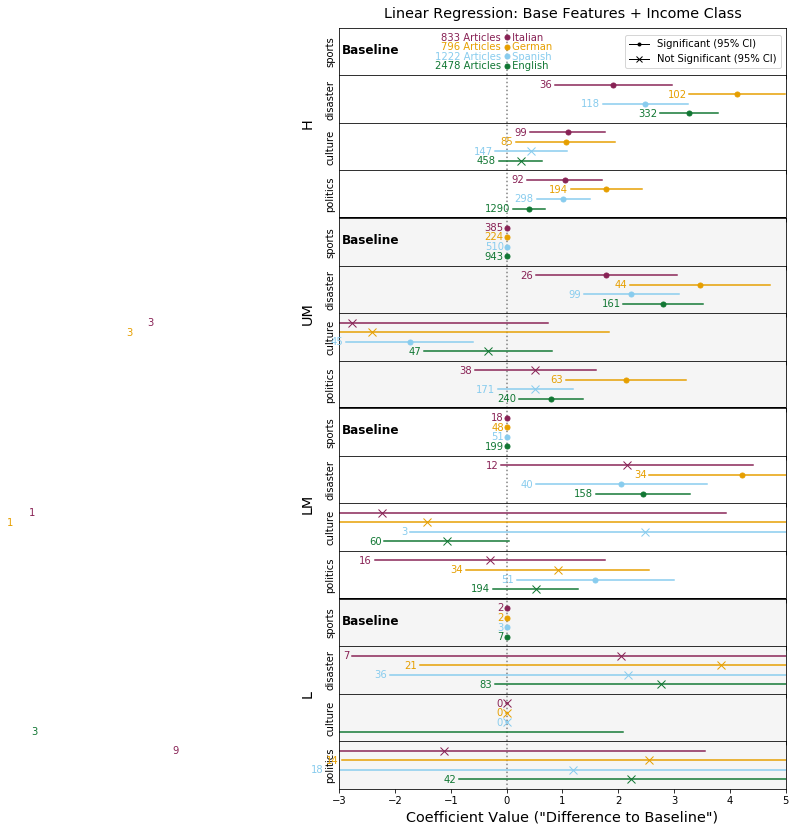

In [85]:
print(" + ".join(features_rq_1).replace('_', '\_'))

figres1 = plot_regression_results_interactions_from_dict(
    df_reg, fit_rq1, 
    ['gni_class:cat'], 
    include_counts=True, figsize=(8, 14), x_limits=(-3,5), title=f'Linear Regression: Base Features + Income Class',
    adjust_overdispersion=True)
figres1.savefig('figures/reg_model1_int.pdf', bbox_inches='tight')

In [93]:
fit_rq1a[code].cov_params()

,Intercept,cat[T.culture],cat[T.disaster],cat[T.politics],planned[T.True],breaking[T.True],population_log,country_cat_articles_log,views_baseline_log,GDP_pc_log,cat[T.culture]:GDP_pc_log,cat[T.disaster]:GDP_pc_log,cat[T.politics]:GDP_pc_log
Intercept,1.263574,-0.558329,-0.659387,-0.666116,-0.027953,-0.010723,-0.046885,0.011885,0.027354,-0.090040,0.055390,0.063703,0.065481
cat[T.culture],-0.558329,3.035292,0.518315,0.495260,0.006130,-0.007322,0.006229,0.007499,-0.007614,0.055923,-0.291567,-0.049254,-0.047456
cat[T.disaster],-0.659387,0.518315,1.229796,0.517336,0.018282,-0.008172,0.011098,0.000419,-0.008607,0.059043,-0.050494,-0.123743,-0.050379
cat[T.politics],-0.666116,0.495260,0.517336,1.135980,0.002989,0.001244,0.010268,-0.001209,-0.003595,0.053644,-0.048852,-0.050777,-0.110962
planned[T.True],-0.027953,0.006130,0.018282,0.002989,0.030698,0.015928,0.000317,-0.000342,-0.000375,0.000218,-0.000561,0.000422,-0.000438
breaking[T.True],-0.010723,-0.007322,-0.008172,0.001244,0.015928,0.060611,-0.000155,-0.000211,0.000089,-0.000358,0.000656,0.000876,-0.000170
population_log,-0.046885,0.006229,0.011098,0.010268,0.000317,-0.000155,0.003011,-0.000525,-0.002082,0.003106,-0.000605,-0.001092,-0.000968
country_cat_articles_log,0.011885,0.007499,0.000419,-0.001209,-0.000342,-0.000211,-0.000525,0.002493,-0.000166,-0.000275,-0.000514,0.000190,0.000385
views_baseline_log,0.027354,-0.007614,-0.008607,-0.003595,-0.000375,0.000089,-0.002082,-0.000166,0.002178,-0.002893,0.000630,0.000741,0.000230
GDP_pc_log,-0.090040,0.055923,0.059043,0.053644,0.000218,-0.000358,0.003106,-0.000275,-0.002893,0.008648,-0.005426,-0.005771,-0.005191


In [108]:
fit_rq1a['de'].cov_params()

,Intercept,cat[T.culture],cat[T.disaster],cat[T.politics],planned[T.True],breaking[T.True],population_log,country_cat_articles_log,views_baseline_log,GDP_pc_log,cat[T.culture]:GDP_pc_log,cat[T.disaster]:GDP_pc_log,cat[T.politics]:GDP_pc_log
Intercept,1.320146,-1.050278,-0.692617,-0.724525,-0.007680,-0.004696,-0.034938,0.037705,0.009329,-0.084361,0.104143,0.070142,0.070621
cat[T.culture],-1.050278,19.927067,0.641711,0.685171,-0.010173,-0.002645,0.023189,-0.025232,-0.001762,0.067608,-1.871836,-0.065368,-0.066497
cat[T.disaster],-0.692617,0.641711,1.403551,0.595833,0.007612,-0.002887,0.006101,-0.012989,-0.000136,0.057901,-0.063793,-0.142495,-0.058810
cat[T.politics],-0.724525,0.685171,0.595833,1.454268,0.007512,0.004342,0.007309,-0.017571,0.002840,0.054940,-0.068592,-0.059335,-0.145341
planned[T.True],-0.007680,-0.010173,0.007612,0.007512,0.018247,0.009171,-0.000150,0.001484,0.000074,-0.000425,0.000539,0.000241,-0.001005
breaking[T.True],-0.004696,-0.002645,-0.002887,0.004342,0.009171,0.040744,-0.000245,0.000401,0.000224,-0.000342,0.000172,-0.000024,-0.000488
population_log,-0.034938,0.023189,0.006101,0.007309,-0.000150,-0.000245,0.001617,-0.001320,-0.000479,0.001415,-0.002287,-0.000700,-0.000665
country_cat_articles_log,0.037705,-0.025232,-0.012989,-0.017571,0.001484,0.000401,-0.001320,0.009101,-0.000312,-0.001783,0.003057,0.001981,0.002231
views_baseline_log,0.009329,-0.001762,-0.000136,0.002840,0.000074,0.000224,-0.000479,-0.000312,0.000813,-0.001236,0.000064,-0.000036,-0.000337
GDP_pc_log,-0.084361,0.067608,0.057901,0.054940,-0.000425,-0.000342,0.001415,-0.001783,-0.001236,0.007792,-0.006623,-0.005807,-0.005418


In [130]:
fit_rq1a[code].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            views_7_sum   No. Observations:                 1577
Model:                            GLM   Df Residuals:                     1564
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14109.
Date:                Wed, 25 May 2022   Deviance:                       569.63
Time:                        09:39:30   Pearson chi2:                 1.95e+03
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.9894      1.623      0.609      0.542      -2.193       4.171
cat[T.culture]                -3.7963      5.458     -0.696      0.487     -14.494       6.902
cat[T.disaster]                1.9686      2.411      0.817      0.414      -2.756       6.693
cat[T.politics]               -5.0880      1.963     -2.592      0.010      -8.936      -1.240
planned[T.True]                2.3970      0.162     14.779      0.000       2.079       2.715
breaking[T.True]              -0.2677      0.229     -1.171      0.242      -0.716       0.181
population_log                 0.2402      0.057      4.199      0.000       0.128       0.352
country_cat_articles_log      -0.3045      0.056     -5.449      0.000      -0.414      -0.195
views_baseline_log             0.0498      0.037      1.333      0.183      -0.023       0.123
GDP_pc_log                     0.0675      0.119      0.566      0.571      -0.166       0.301
GDP_pc_log:cat[T.culture]      0.4520      0.514      0.880      0.379      -0.555       1.459
GDP_pc_log:cat[T.disaster]    -0.0139      0.250     -0.055      0.956      -0.504       0.476
GDP_pc_log:cat[T.politics]     0.5880      0.198      2.967      0.003       0.200       0.976
==============================================================================================
"""

In [156]:
from regression import compute_significance_continuous

compute_significance_continuous(fit_rq1a, codes, df_reg.cat.unique())

en
GDP_pc_log for disaster: 0.101 0.100 [-0.103, 0.306] o
GDP_pc_log for culture: 0.343 0.162 [0.014, 0.672] *
GDP_pc_log for sports: -0.112 0.093 [-0.302, 0.077] o
GDP_pc_log for politics: -0.290 0.096 [-0.486, -0.095] *
es
GDP_pc_log for disaster: 0.008 0.161 [-0.295, 0.312] o
GDP_pc_log for culture: 0.040 0.346 [-0.614, 0.694] o
GDP_pc_log for sports: -0.413 0.113 [-0.627, -0.199] *
GDP_pc_log for politics: -0.150 0.146 [-0.426, 0.126] o
de
GDP_pc_log for disaster: 0.143 0.105 [-0.252, 0.539] o
GDP_pc_log for culture: 1.393 0.413 [-0.160, 2.946] o
GDP_pc_log for sports: -0.018 0.088 [-0.350, 0.313] o
GDP_pc_log for politics: 0.108 0.108 [-0.299, 0.515] o
it
GDP_pc_log for disaster: 0.054 0.234 [-0.457, 0.564] o
GDP_pc_log for culture: 0.520 0.493 [-0.558, 1.597] o
GDP_pc_log for sports: 0.067 0.119 [-0.193, 0.328] o
GDP_pc_log for politics: 0.655 0.178 [0.267, 1.044] *


C(cat, Treatment(reference="sports")) + population\_log + country\_cat\_articles\_log + views\_baseline\_log + planned + breaking + C(gni\_class, Treatment(reference="H")) + C(gni\_region, Treatment(reference="North America")) + C(gni\_region, Treatment(reference="North America")):C(cat, Treatment(reference="sports")) + C(gni\_class, Treatment(reference="H")):C(cat, Treatment(reference="sports"))


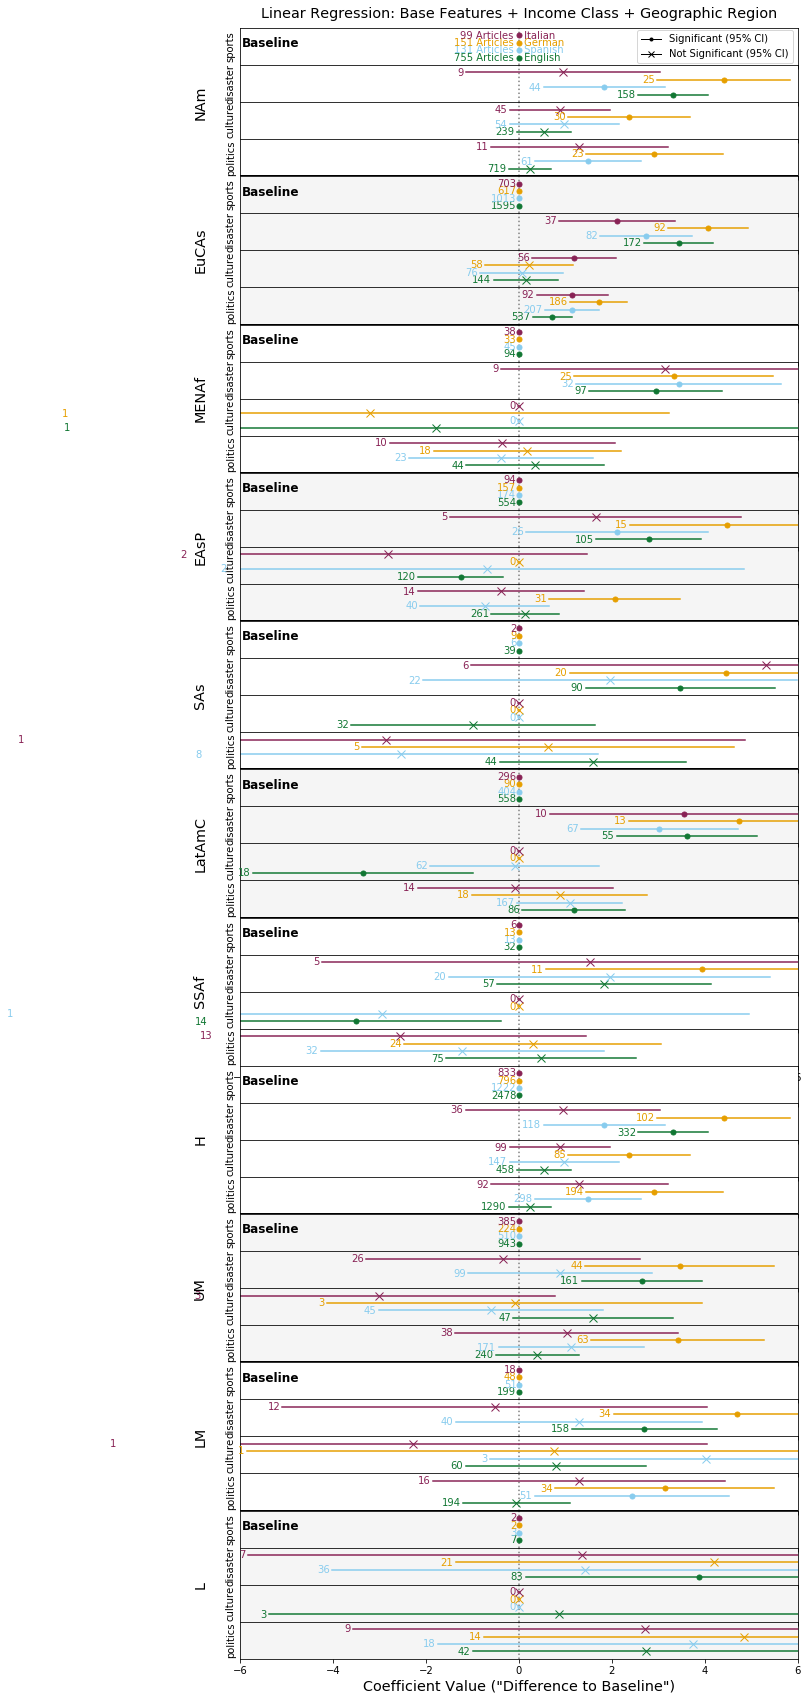

In [147]:
print(" + ".join(features_both).replace('_', '\_'))

figres_both = plot_regression_results_interactions_from_dict(
    df_reg, fit_both, 
    ['gni_region:cat', 'gni_class:cat'], 
    include_counts=True, figsize=(10, 30), x_limits=(-6,6), title=f'Linear Regression: Base Features + Income Class + Geographic Region',
    adjust_overdispersion=True)
figres_both.savefig('figures/reg_model_both_int.pdf', bbox_inches='tight')

## no planned/breaking

C(cat, Treatment(reference="sports")) + population\_log + country\_cat\_articles\_log + views\_baseline\_log + planned + breaking


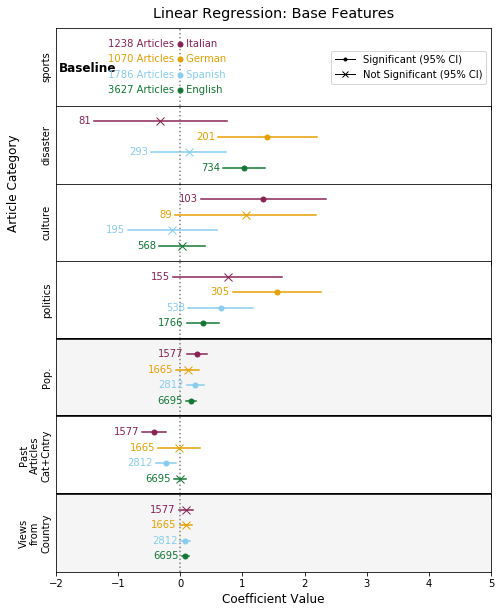

In [291]:
#coefficients = [string.strip() for string in features_no_red.split('+')]
print(" + ".join(features_no_red).replace('_', '\_'))

figres0_nobin = plot_regression_results_from_dict(
    df_reg, fit_0_nobin, 
    ['cat', 'population_log', 'country_cat_articles_log', 'views_baseline_log'], 
    include_counts=True, figsize=(7.8, 10), x_limits=(-2,5), title=f'Linear Regression: Base Features', adjust_overdispersion=True)
figres0_nobin.savefig('figures/reg_model0_nobin.pdf', bbox_inches='tight')

C(cat, Treatment(reference="sports")) + population\_log + country\_cat\_articles\_log + views\_baseline\_log + planned + breaking + C(gni\_class, Treatment(reference="H"))


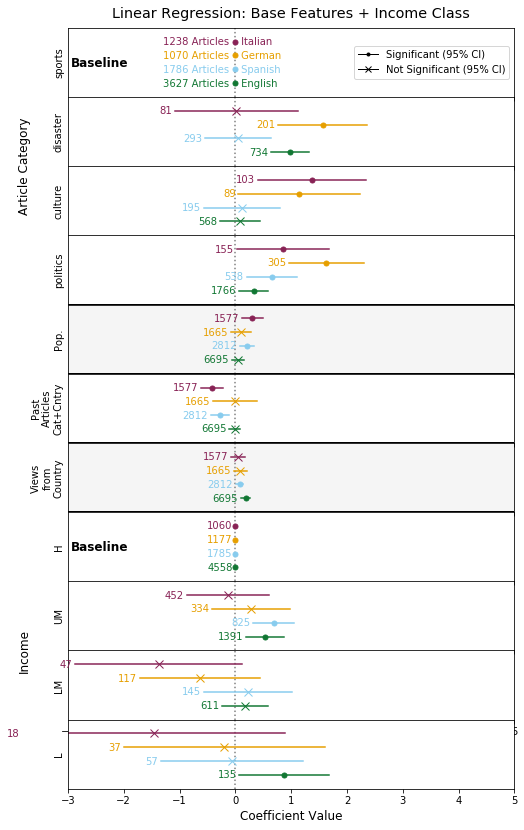

In [323]:
print(" + ".join(features_rq_1).replace('_', '\_'))

figres1_nobin = plot_regression_results_from_dict(
    df_reg, fit_rq1_nobin, 
    ['cat', 'population_log', 'country_cat_articles_log', 'views_baseline_log', 'gni_class'], 
    include_counts=True, figsize=(8, 14), x_limits=(-3,5), title=f'Linear Regression: Base Features + Income Class',
    adjust_overdispersion=True)
figres1_nobin.savefig('figures/reg_model1_nobin.pdf', bbox_inches='tight')

C(cat, Treatment(reference="sports")) + population\_log + country\_cat\_articles\_log + views\_baseline\_log + planned + breaking + GDP\_pc\_z


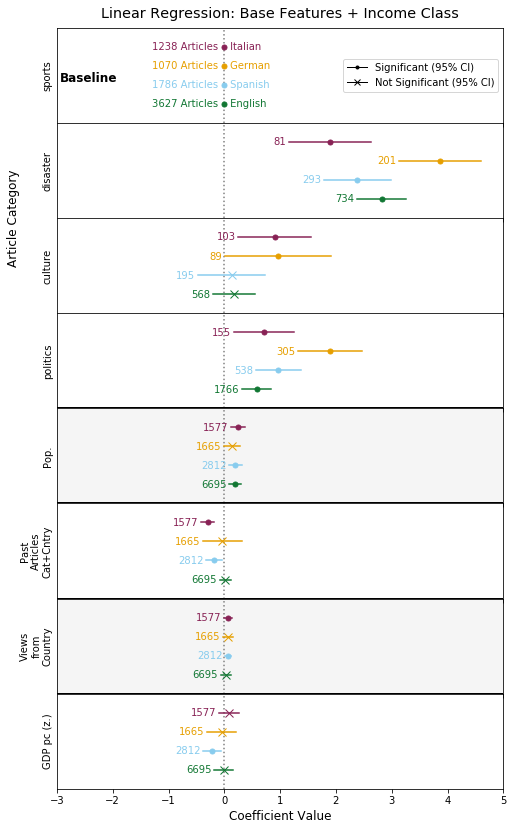

In [325]:
print(" + ".join(features_rq_1a_nobin).replace('_', '\_'))

figres1a_nobin = plot_regression_results_from_dict(
    df_reg, fit_rq1a_nobin, 
    ['cat', 'population_log', 'country_cat_articles_log', 'views_baseline_log', 'GDP_pc_z'], 
    include_counts=True, figsize=(8, 14), x_limits=(-3,5), title=f'Linear Regression: Base Features + Income Class',
    adjust_overdispersion=True)
figres1a_nobin.savefig('figures/reg_model1a_nobin.pdf', bbox_inches='tight')

C(cat, Treatment(reference="sports")) + population\_log + country\_cat\_articles\_log + views\_baseline\_log + planned + breaking + C(gni\_region, Treatment(reference="North America"))


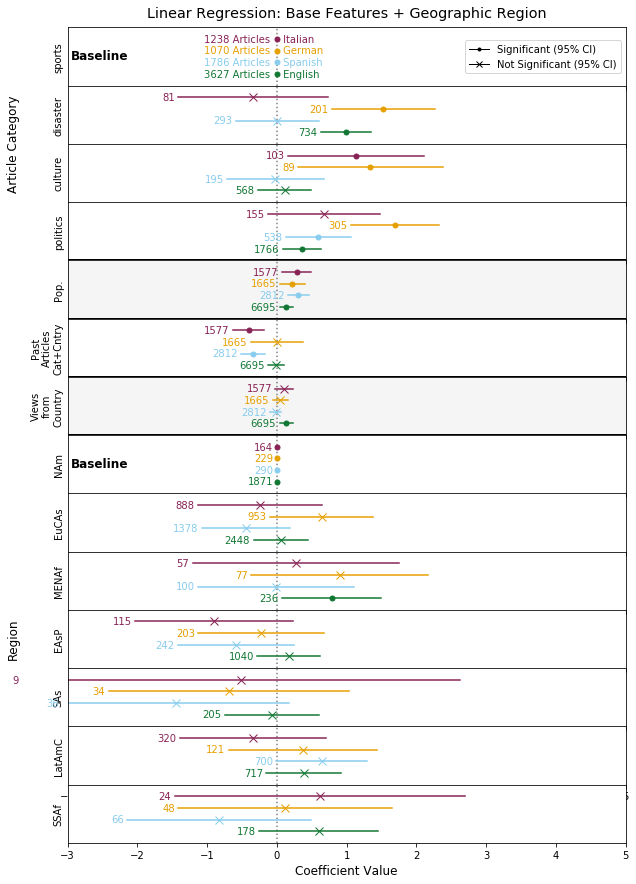

In [326]:
print(" + ".join(features_rq_2).replace('_', '\_'))

figres2_nobin = plot_regression_results_from_dict(
    df_reg, fit_rq2_nobin, 
    ['cat', 'population_log', 'country_cat_articles_log', 'views_baseline_log', 'gni_region'], 
    include_counts=True, figsize=(10, 15), x_limits=(-3,5), title=f'Linear Regression: Base Features + Geographic Region', adjust_overdispersion=True)
figres2_nobin.savefig('figures/reg_model2_nobin.pdf', bbox_inches='tight')

C(cat, Treatment(reference="sports")) + population\_log + country\_cat\_articles\_log + views\_baseline\_log + planned + breaking + C(gni\_class, Treatment(reference="H")) + C(gni\_region, Treatment(reference="North America"))


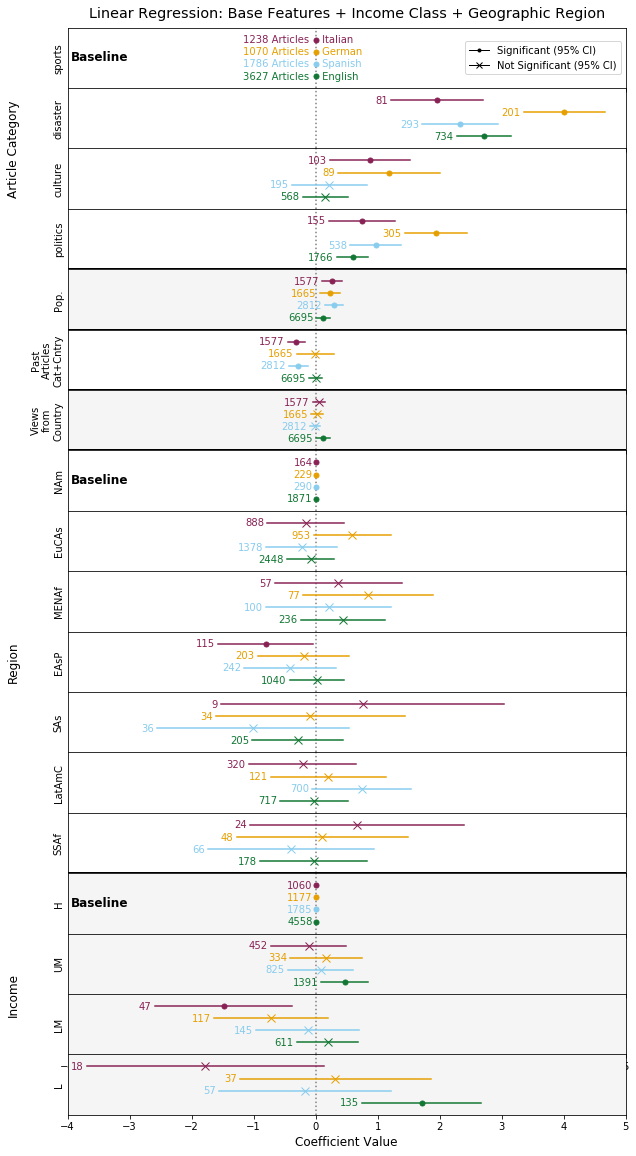

In [327]:
print(" + ".join(features_both).replace('_', '\_'))

figres_both_nobin = plot_regression_results_from_dict(
    df_reg, fit_both, 
    ['cat', 'population_log', 'country_cat_articles_log', 'views_baseline_log', 'gni_region', 'gni_class'], 
    include_counts=True, figsize=(10, 20), x_limits=(-4,5), title=f'Linear Regression: Base Features + Income Class + Geographic Region', adjust_overdispersion=True)
figres_both_nobin.savefig('figures/reg_model_both_nobin.pdf', bbox_inches='tight')